# **Multi-Host Particle Mesh Simulation**

In this notebook, we extend our Particle Mesh simulation across **multiple nodes**, enabling simulations at scales not achievable on a single machine. By leveraging distributed GPUs across hosts, we handle larger mesh shapes and box sizes efficiently.

> **Note**: Since there’s no direct way to run a multi-host notebook, I’ll guide you step by step on how to submit an interactive job from a script.


To run a multi-host simulation, you first need to **allocate a job** with `salloc`. This command requests resources on an HPC cluster.

> **Note**: You can alternatively use `sbatch` with a SLURM script to submit the job. The exact `salloc` parameters may vary depending on your specific HPC cluster configuration.


In [ ]:
!salloc --account=XXX@a100 -C a100 --gres=gpu:8 --ntasks-per-node=8 --time=00:40:00  --cpus-per-task=8 --hint=nomultithread --qos=qos_gpu-dev --nodes=4 & 

> **Note**: These `salloc` parameters are configured for the **Jean Zay** supercomputer in France. Adaptations might be necessary if using a different HPC cluster.


**A few hours later**

Use `!squeue -u $USER -o "%i %D %b"` to **check the JOB ID** and verify your resource allocation.

In this example, we’ve been allocated **32 GPUs split across 4 nodes**.


In [19]:
!squeue -u $USER -o "%i %D %b"

JOBID NODES TRES_PER_NODE
467745 4 gres/gpu:8


Unset the following environment variables, as they can cause issues when using JAX in a distributed setting:

In [ ]:
import os
del os.environ['VSCODE_PROXY_URI']
del os.environ['NO_PROXY']
del os.environ['no_proxy']

### Checking Available Compute Resources

Run the following command to initialize JAX distributed computing and display the devices available for this job:


In [21]:
!srun --jobid=467745 -n 32 python -c "import jax; jax.distributed.initialize(); print(jax.devices()) if jax.process_index() == 0 else None"

[CudaDevice(id=0), CudaDevice(id=1), CudaDevice(id=2), CudaDevice(id=3), CudaDevice(id=4), CudaDevice(id=5), CudaDevice(id=6), CudaDevice(id=7), CudaDevice(id=8), CudaDevice(id=9), CudaDevice(id=10), CudaDevice(id=11), CudaDevice(id=12), CudaDevice(id=13), CudaDevice(id=14), CudaDevice(id=15), CudaDevice(id=16), CudaDevice(id=17), CudaDevice(id=18), CudaDevice(id=19), CudaDevice(id=20), CudaDevice(id=21), CudaDevice(id=22), CudaDevice(id=23), CudaDevice(id=24), CudaDevice(id=25), CudaDevice(id=26), CudaDevice(id=27), CudaDevice(id=28), CudaDevice(id=29), CudaDevice(id=30), CudaDevice(id=31)]


### Running the Multi-Host Simulation Script

Run the simulation script across 32 processes:

```bash
!srun --jobid=467745 -n 32 python 05-MultiHost_PM.py --mesh_shape 1024 1024 1024 --box_size 1000. 1000. 1000. --halo_size 128 -s leapfrog --pdims 16 2
```
The script, located in the same path as this notebook, is named [**05-MultiHost_PM.py**](05-MultiHost_PM.py).


### Multi-Host Simulation Script with Arguments

This script is nearly identical to the single-host version, with the main addition being the call to `jax.distributed.initialize()` at the start, enabling multi-host parallelism. Here’s a breakdown of the key arguments:

- **`--pdims`** (`-p`): Specifies processor grid dimensions as two integers, like `16 2` for 16 x 2 device mesh (default is `[1, jax.devices()]`).
- **`--mesh_shape`** (`-m`): Defines the simulation mesh shape as three integers (default is `[512, 512, 512]`).
- **`--box_size`** (`-b`): Sets the physical box size of the simulation as three floating-point values, e.g., `1000. 1000. 1000.` (default is `[500.0, 500.0, 500.0]`).
- **`--halo_size`** (`-H`): Specifies the halo size for boundary overlap across nodes (default is `64`).
- **`--solver`** (`-s`): Chooses the ODE solver (`leapfrog` or `dopri8`). The `leapfrog` solver uses a fixed step size, while `dopri8` is an adaptive Runge-Kutta solver with a PID controller (default is `leapfrog`).
- **`--snapthots`** (`-st`) : Number of snapshots to save (warning, increases memory usage)

The script also saves results across nodes.


In [ ]:
import subprocess

# Define parameters as variables
jobid = "467745"
num_processes = 32
script_name = "05-MultiHost_PM.py"
mesh_shape = (1024, 1024, 1024)
box_size = (1000., 1000., 1000.)
halo_size = 128
solver = "leapfrog"
pdims = (16, 2)
snapshots = 2

# Build the command as a list, incorporating variables
command = [
    "srun",
    f"--jobid={jobid}",
    "-n", str(num_processes),
    "python", script_name,
    "--mesh_shape", str(mesh_shape[0]), str(mesh_shape[1]), str(mesh_shape[2]),
    "--box_size", str(box_size[0]), str(box_size[1]), str(box_size[2]),
    "--halo_size", str(halo_size),
    "-s", solver,
    "--pdims", str(pdims[0]), str(pdims[1]),
    "--snapshots", str(snapshots)
]

# Execute the command as a subprocess
subprocess.run(command)


### Loading and Visualizing Results

After running the multi-host simulation, we load the saved results from disk:

- **`initial_conditions.npy`**: Initial conditions for the simulation.
- **`lpt_displacements.npy`**: Linear perturbation displacements.
- **`ode_solution_0.npy`** and **`ode_solution_1.npy`**: Solutions from the ODE solver at each snapshot.

We then use `plot_fields_single_projection` to visualize these fields and observe the results across multiple snapshots.


In [1]:
import numpy as np

initial_conditions = np.load('fields/initial_conditions.npy')
lpt_displacements = np.load('fields/lpt_displacements.npy')
ode_solution_0 = np.load('fields/ode_solution_0.npy')
ode_solution_1 = np.load('fields/ode_solution_1.npy')

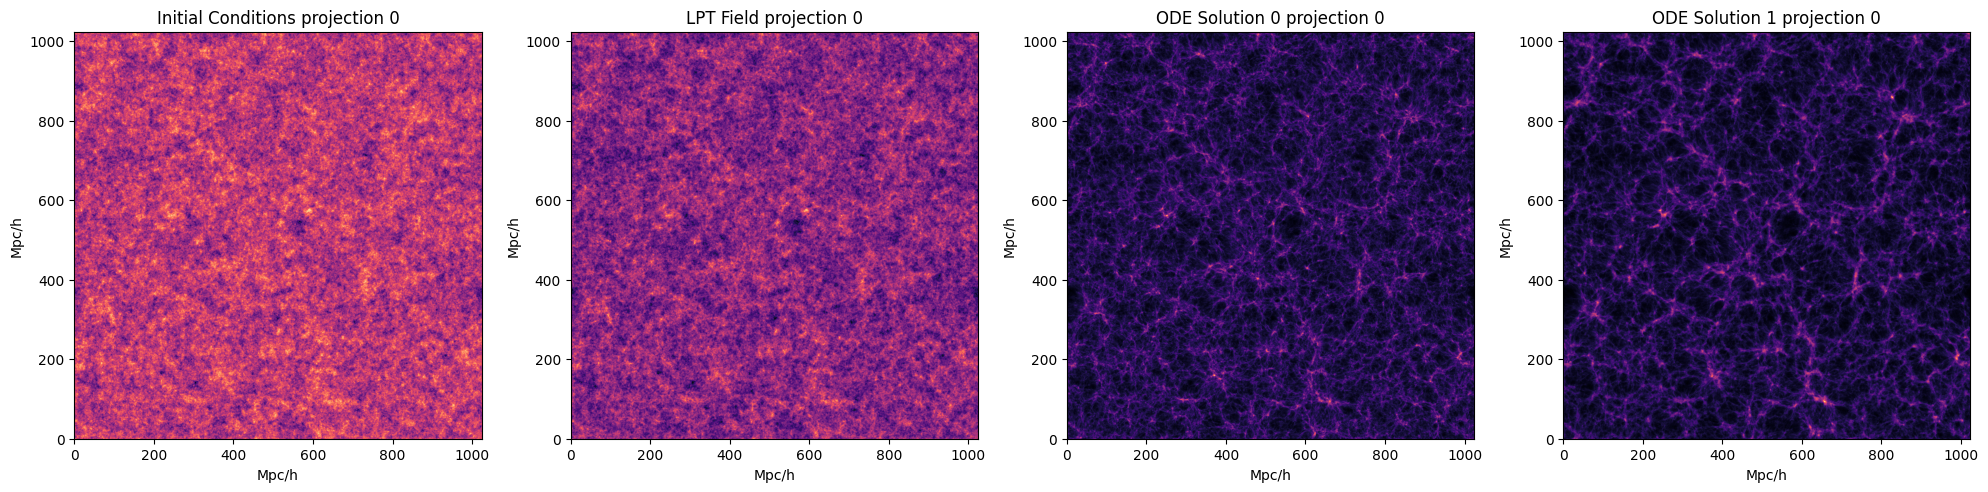

In [2]:
from jaxpm.plotting import plot_fields_single_projection
fields = {
    "Initial Conditions": initial_conditions,
    "LPT Field": lpt_displacements,
    "ODE Solution 0": ode_solution_0,
    "ODE Solution 1": ode_solution_1
}
plot_fields_single_projection(fields)